# Loan Status Prediction

Dream Housing Finance company deals in all home loans. They have presence across all urban, semi urban and rural areas. Customer first apply for home loan after that company validates the customer eligibility for loan.

The Company wants to automate the loan eligibility process (real time) based on customer detail provided while filling online application form. These details are Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and others. To automate this process, they have given a problem to identify the customers segments, those are eligible for loan amount so that they can specifically target these customers.

It’s a classification problem , given information about the application we have to predict whether the they’ll be able to pay the loan or not.

The data consists of the following rows:
Variable | Description
----------|--------------
Loan_ID | Unique Loan ID
Gender | Male/ Female
Married | Applicant married (Y/N)
Dependents | Number of dependents
Education | Applicant Education (Graduate/ Under Graduate)
Self_Employed | Self employed (Y/N)
ApplicantIncome | Applicant income
CoapplicantIncome | Coapplicant income
LoanAmount | Loan amount in thousands
Loan_Amount_Term | Term of loan in months
Credit_History | credit history meets guidelines
Property_Area | Urban/ Semi Urban/ Rural
Loan_Status | Loan approved (Y/N)

In [65]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [66]:
loan = pd.read_csv('Loan.csv')
loan.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [67]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


## Data preprocessing

**Deal with missing values**

In [68]:
loan.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

**For categorical values, fill the missing values with the mode**

In [69]:
loan['Gender'].fillna(loan['Gender'].mode()[0], inplace=True)
loan['Married'].fillna(loan['Married'].mode()[0], inplace=True)
loan['Dependents'].fillna(loan['Dependents'].mode()[0], inplace=True)
loan['Self_Employed'].fillna(loan['Self_Employed'].mode()[0], inplace=True)

loan['Credit_History'].fillna(loan['Credit_History'].mode()[0], inplace=True)

**For numerical values, fill the missing values with the mean or median**

In [70]:
loan[['LoanAmount', 'Loan_Amount_Term', 'Credit_History']].describe()

,LoanAmount,Loan_Amount_Term,Credit_History
count,592.000000,600.00000,614.000000
mean,146.412162,342.00000,0.855049
std,85.587325,65.12041,0.352339
min,9.000000,12.00000,0.000000
25%,100.000000,360.00000,1.000000
50%,128.000000,360.00000,1.000000
75%,168.000000,360.00000,1.000000
max,700.000000,480.00000,1.000000


In [71]:
loan['LoanAmount'].fillna(loan.LoanAmount.median(), inplace=True)
loan['Loan_Amount_Term'].fillna(loan.Loan_Amount_Term.median(), inplace=True)

In [72]:
loan.shape

(614, 13)

## Outliers

In [73]:
df = loan.copy()
df = df.drop('Loan_ID', axis=1)

<Axes: xlabel='LoanAmount', ylabel='Count'>

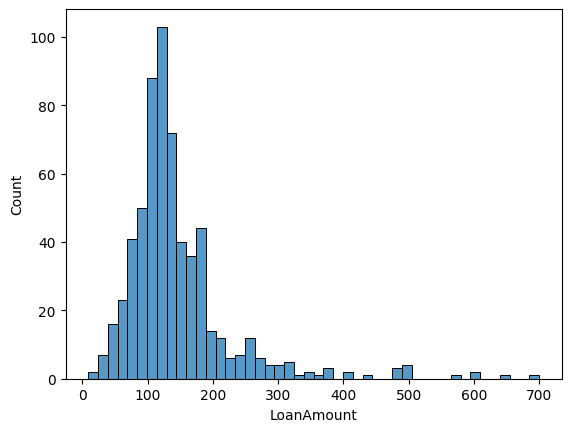

In [74]:
sns.histplot(df['LoanAmount'], kde=False)

To handle the outliers, one solution is just to remove them, but we can also log transform them to nullify their effect.  
Also, some people might have a low income but strong CoapplicantIncome, so a good idea may be to combine them in TotalIncome column.

In [75]:
df['LoanAmount_log'] = np.log(df['LoanAmount'])
df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']
df['TotalIncome_log'] = np.log(df['TotalIncome'])

In [76]:
df = df.drop(['LoanAmount', 'TotalIncome', 'ApplicantIncome', 'CoapplicantIncome'], axis=1)

Plotting the histogram of loan amount log we can see that it's a normal distribution.

<Axes: xlabel='LoanAmount_log', ylabel='Count'>

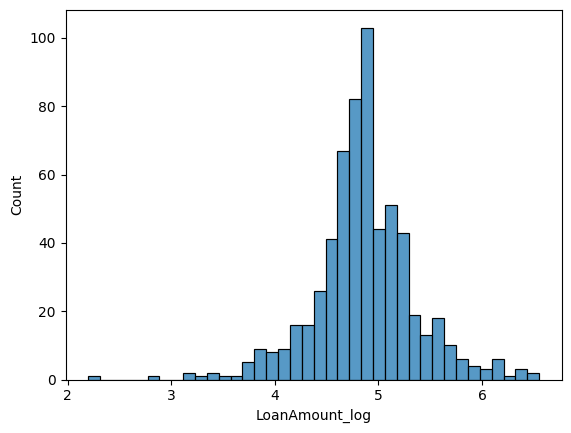

In [77]:
sns.histplot(df['LoanAmount_log'])

## Encoding

### Display unique values for each column

In [78]:
def unique_column_values(columns):
    for col in columns:
        unique_values = df[col].unique()
        print(f'{col}:\t {unique_values}')

In [79]:
unique_column_values(df.select_dtypes(exclude='number').columns)

Gender:	 ['Male' 'Female']
Married:	 ['No' 'Yes']
Dependents:	 ['0' '1' '2' '3+']
Education:	 ['Graduate' 'Not Graduate']
Self_Employed:	 ['No' 'Yes']
Property_Area:	 ['Urban' 'Rural' 'Semiurban']
Loan_Status:	 ['Y' 'N']


### Convert categorical column to numeric representation

In [80]:
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})
df['Married'] = df['Married'].map({'No': 0, 'Yes': 1})
df['Self_Employed'] = df['Self_Employed'].map({'No': 0, 'Yes': 1})
df['Education'] = df['Education'].map({'Not Graduate': 0, 'Graduate': 1})
df['Loan_Status'] = df['Loan_Status'].map({'N': 0, 'Y': 1})

In [81]:
df['Dependents'] = df['Dependents'].replace('3+', 3)
df['Dependents'].unique()

array(['0', '1', '2', 3], dtype=object)

In [82]:
df['Dependents'] = df['Dependents'].astype(int)
df['Dependents'].unique()

array([0, 1, 2, 3])

### One Hot Encoding

In [83]:
df_encoded = pd.get_dummies(df['Property_Area'], drop_first=True).astype(int)
df = pd.concat([df, df_encoded], axis=1)

# Dropt the original 'Property_Area' column
df.drop('Property_Area', axis=1, inplace=True)
df.head(3)

,Gender,Married,Dependents,Education,Self_Employed,Loan_Amount_Term,Credit_History,Loan_Status,LoanAmount_log,TotalIncome_log,Semiurban,Urban
0,0,0,0,1,0,360.0,1.0,1,4.852030,8.674026,0,1
1,0,1,1,1,0,360.0,1.0,0,4.852030,8.714568,0,0
2,0,1,0,1,1,360.0,1.0,1,4.189655,8.006368,0,1


## Correlation

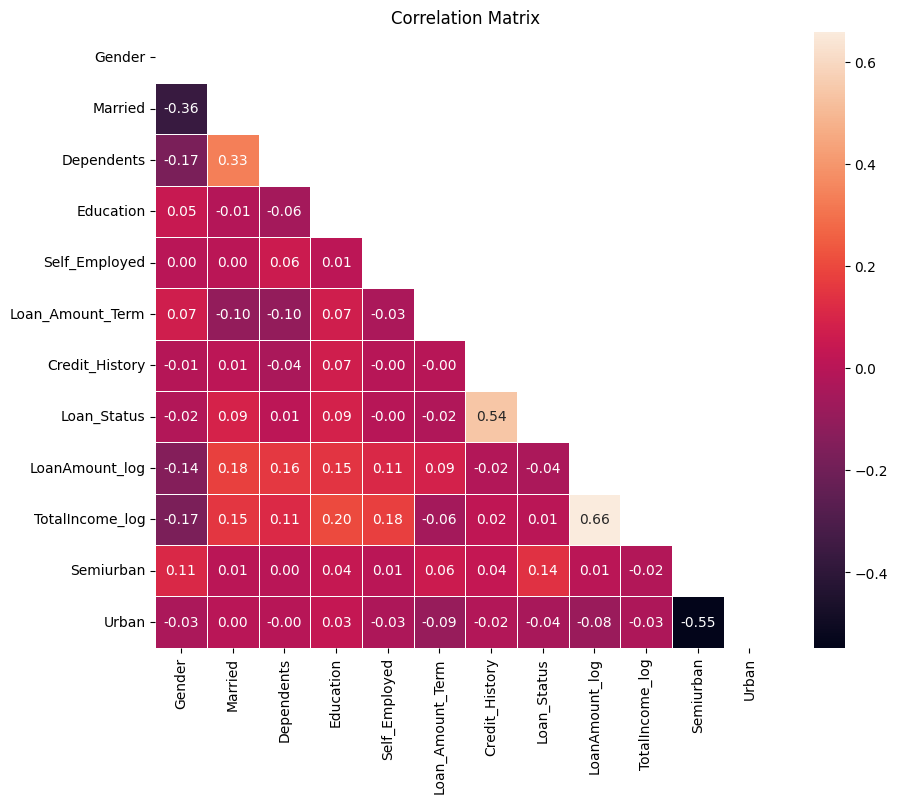

In [84]:
corr_matrix = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", linewidths=0.5, ax=ax)
plt.title('Correlation Matrix')
plt.show() 

## Finding Optimal Models and Hyperparameters

In [85]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

In [86]:
from sklearn.model_selection import GridSearchCV

In [87]:
X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']

In [88]:
model_params = {
    'svm': {
        'model': SVC(gamma='auto'),
        'params': {
            'C': [1, 10, 20],
            'kernel': ['rbf']
        }
    },
    'knn': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 10]
        }
    },
    'decision_tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini', 'entropy']
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [1, 5, 10]
        }
    },
    'logistic_regression': {
        'model': LogisticRegression(solver='liblinear', multi_class='auto'),
        'params': {
            'C': [1, 5, 10],
        }
    },
    'naive_bayes_gaussian': {
        'model': GaussianNB(),
        'params': {}
    },
    'naive_bayes_multinomial': {
        'model': MultinomialNB(),
        'params': {}
    }
}

In [89]:
scores = []

for model_name, mp in model_params.items():
    print(f'Running {model_name} model...')
    clf = GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(X, y)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

df2 = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])
df2

Running svm model...
Running knn model...
Running decision_tree model...
Running random_forest model...
Running logistic_regression model...
Running naive_bayes_gaussian model...
Running naive_bayes_multinomial model...


,model,best_score,best_params
0,svm,0.794815,"{'C': 1, 'kernel': 'rbf'}"
1,knn,0.757270,{'n_neighbors': 10}
2,decision_tree,0.721485,{'criterion': 'entropy'}
3,random_forest,0.754138,{'n_estimators': 5}
4,logistic_regression,0.809463,{'C': 10}
5,naive_bayes_gaussian,0.802959,{}
6,naive_bayes_multinomial,0.697055,{}


**Here, the best model is LogisticRegression (C=1)**

## Logistic Regression

In [90]:
from sklearn.model_selection import train_test_split

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [99]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [100]:
lr.score(X_test, y_test)

0.8130081300813008

## Model Performance Analysis

**Confusion Matrix**

In [101]:
y_predicted = lr.predict(X_test)

In [102]:
from sklearn.metrics import confusion_matrix

In [103]:
cm = confusion_matrix(y_test, y_predicted)
cm

array([[10, 18],
       [ 5, 90]], dtype=int64)

Text(33.22222222222222, 0.5, 'Truth')

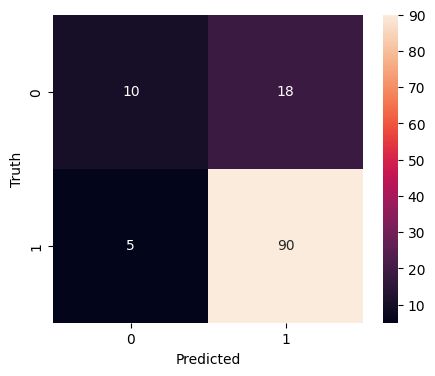

In [104]:
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')